![image](images\YAH.png)

In [1]:
import random, math
import numpy as np
from matplotlib import pyplot as plt

def sigmoid(x):
    return 1/(1+np.exp(-np.clip(x, -500, 500)))

def swish(x):
    return x*sigmoid(x)

def relu(x):
    return np.maximum(0,x)

def softmax(x):
    p = np.exp(x - np.max(x))
    return p/np.sum(p)

def MSE(target, x):
    return np.power(target - x, 2)

def activation_function(z, act, derivative=False, activated_value=None):
    if derivative == False:
        if act=="sigmoid":
            return sigmoid(z)
        elif act == "swish":
            return swish(z)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return np.tanh(z)
        elif act=="softmax":
            return softmax(z)
    else:
        if act=="sigmoid":
            return sigmoid(z)
        elif act == "swish":
            return activated_value + np.multiply(sigmoid(z), 1 - activated_value)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return 1 - np.power(activated_value, 2)
        elif act=="softmax":
            return softmax(z)
    
    

class RNN():
    
    def __init__(self, l_rate):
        self.layers = []
        self.learning_rate = l_rate
        
    def add_layer(self, input_size, output_size, activation=None, last_activation=None):
        new_layer = Layer(input_size, output_size, activation)
        self.layers.append(new_layer)
        
    def forward_pass(self, input_data):
        self.layers[0].forward_pass(input_data)
        for i in range(1, len(self.layers)):
            prev_layer_out = self.layers[i-1].Y[-1]
            self.layers[i].forward_pass(prev_layer_out)
            
        return self.layers[-1].Y[-1]
            
    def clear_memory(self):
        for i in range(0, len(self.layers)):
            self.layers[i].clear_memory()
            
    def backpropagation_through_time(self, input_data, target, max_steps):
        gradient, loss = self.layers[-1].der_MSE(target)
        for i in range(1, len(self.layers)):
            inputs = self.layers[-i-1].Y
            gradient = self.layers[-i].descent(gradient, inputs, self.learning_rate, max_steps)
        self.layers[0].descent(gradient, input_data, self.learning_rate, max_steps)
        return loss
            
class Layer():
    
    def __init__(self, input_size, output_size, activation=None, last_activation=None):
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        self.last_activation = last_activation
        
        self.weights_X = self.weights_init(output_size, input_size)
        self.weights_H = self.weights_init(output_size, output_size)
        self.weights_Y = self.weights_init(output_size, output_size)
        self.bias      = self.weights_init(output_size, 1)
        
        self.A = np.empty((0,output_size,1))
        self.Y = np.empty((0,output_size,1))
        self.H = np.empty((0,output_size,1))
        
        
    def weights_init(self, rows, cols):
        return np.random.uniform(-1,1,(rows, cols))
    
    
    def forward_pass(self, input_data):
        new_H = self.weights_X.dot(input_data) + self.bias
        if len(self.A) > 0:
             new_H += self.weights_H.dot(self.A[-1]) 
        self.H = np.append(self.H, np.array([new_H]), axis=0)
        
        
        new_A = activation_function(self.H[-1], self.activation)
        self.A = np.append(self.A, np.array([new_A]), axis=0)
        
        
        new_Y = self.weights_Y.dot(self.A[-1])
        if self.last_activation != None:
            new_Y = activation_function(new_Y, self.last_activation)
        self.Y = np.append(self.Y, np.array([new_Y]), axis=0)
        

    def clear_memory(self):
        self.A = np.empty((0, self.output_size, 1))
        self.Y = np.empty((0, self.output_size, 1))
        self.H = np.empty((0, self.output_size, 1))
        
        
    def der_MSE(self, target):
        return 2*(self.Y[-1] - target), np.power(target - self.Y[-1], 2)
     
    
    def descent(self, gradient, input_data, learning_rate, max_steps):
        input_matrix = np.array(input_data)
        
        dC_Wh = 0
        dC_Wx = 0
        dC_B = 0
        
        dY_Wy = np.tile(self.A[-1].T, (self.weights_Y.shape[0], 1))
        dC_Wy = np.multiply(np.tile(gradient, (1, self.weights_Y.shape[1])), dY_Wy)
        
        dY_A = np.sum(self.weights_Y, axis=0, keepdims=True).T
        dC_A = np.multiply(gradient, dY_A)
        dA_H = activation_function(self.H[-1], self.activation, derivative=True, activated_value=self.A[-1])
        dC_H = np.multiply(gradient, dA_H)
        dC_H_transformed_forX = np.tile(dC_H, (1, self.weights_X.shape[1]))
        dC_X = np.sum(np.multiply(self.weights_X, dC_H_transformed_forX), axis=0, keepdims=True).T
        
        
        dA_Wh = np.empty(self.A[-1].shape)
        dA_Wh.fill(1)
        for i in range(0, min(len(self.A), max_steps)):
            dA_Wh = np.multiply(dA_Wh, activation_function(self.H[i], self.activation, derivative=True, activated_value=self.A[i]))
            if i == min(len(self.A), max_steps)-1:
                break
            dA_Wh = np.multiply(dA_Wh, np.sum(self.weights_H, axis=0, keepdims=True).T)
            dA_Wh += self.A[i]
        dC_Wh = np.multiply(dA_Wh, dC_A)
        dC_Wh = np.tile(dC_Wh, (1, self.weights_H.shape[1]))
        
        
        dA_Wx = np.sum(np.tile(input_matrix[0].T, (self.weights_X.shape[0], 1)), axis=1, keepdims=True)
        for i in range(0, min(len(self.A), max_steps)):
            dA_H_temp = activation_function(self.H[i], self.activation, derivative=True, activated_value=self.A[i])
            dA_Wx = np.multiply(dA_H_temp, dA_Wx)
            if i == min(len(self.A), max_steps)-1:
                break
            dA_Wx = np.multiply(np.sum(self.weights_H, axis=0, keepdims=True).T, dA_Wx)
            dA_Wx += np.sum(np.tile(input_matrix[i+1].T, (self.weights_X.shape[0], 1)), axis=1, keepdims=True)
        dC_Wx = np.multiply(dA_Wx, dC_A)
        dC_Wx = np.tile(dC_Wx, (1, self.weights_X.shape[1]))
        
        
        dA_B = np.empty(self.A[-1].shape)
        dA_B.fill(1)
        for i in range(0, min(len(self.A), max_steps)):
            dA_B = np.multiply(dA_B, activation_function(self.H[i], self.activation, derivative=True, activated_value=self.A[i]))
            if i == min(len(self.A), max_steps)-1:
                break
            dA_B = np.multiply(dA_B, np.sum(self.weights_H, axis=0, keepdims=True).T)
            dA_B += 1
        dC_B = np.multiply(dA_B, dC_A)
        
        """weights update"""
        self.weights_Y -= learning_rate * dC_Wy
        self.weights_H -= learning_rate * dC_Wh
        self.bias      -= learning_rate * dC_B
        self.weights_X -= learning_rate * dC_Wx
        
        return dC_X
    

In [2]:
network = RNN(0.001)
network.add_layer(1, 5, "tanh")
network.add_layer(5, 1, "swish")

In [3]:
input_data = [
    [[0.0]],
    [[0.8]],
    [[0.0]],
    [[0.8]],
    [[0.0]],
    [[0.8]],
    [[0.0]],
    [[0.8]],
]

---------------
epoch 0
sample 0
output: 
[[0.06140867]]
target: 
[[0.8]]
---------------
epoch 0
sample 1
output: 
[[0.08793334]]
target: 
[[0.0]]
---------------
epoch 0
sample 2
output: 
[[-0.41664909]]
target: 
[[0.8]]
---------------
epoch 0
sample 3
output: 
[[0.10385004]]
target: 
[[0.0]]
---------------
epoch 0
sample 4
output: 
[[0.09394049]]
target: 
[[0.8]]
---------------
epoch 0
sample 5
output: 
[[-0.17652044]]
target: 
[[0.0]]
---------------
epoch 0
sample 6
output: 
[[0.00719537]]
target: 
[[0.8]]
-----------------average loss: [[0.40031099]]


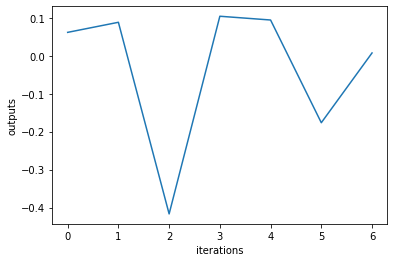

---------------
epoch 500
sample 0
output: 
[[0.36115799]]
target: 
[[0.8]]
---------------
epoch 500
sample 1
output: 
[[-0.045846]]
target: 
[[0.0]]
---------------
epoch 500
sample 2
output: 
[[0.89461204]]
target: 
[[0.8]]
---------------
epoch 500
sample 3
output: 
[[-0.02197135]]
target: 
[[0.0]]
---------------
epoch 500
sample 4
output: 
[[0.80327309]]
target: 
[[0.8]]
---------------
epoch 500
sample 5
output: 
[[-0.020627]]
target: 
[[0.0]]
---------------
epoch 500
sample 6
output: 
[[0.86867041]]
target: 
[[0.8]]
-----------------average loss: [[0.02615877]]


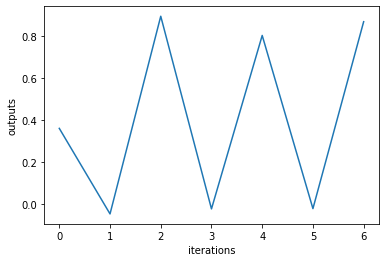

---------------
epoch 1000
sample 0
output: 
[[0.69628189]]
target: 
[[0.8]]
---------------
epoch 1000
sample 1
output: 
[[-0.06302818]]
target: 
[[0.0]]
---------------
epoch 1000
sample 2
output: 
[[0.84399034]]
target: 
[[0.8]]
---------------
epoch 1000
sample 3
output: 
[[-0.03733787]]
target: 
[[0.0]]
---------------
epoch 1000
sample 4
output: 
[[0.78422732]]
target: 
[[0.8]]
---------------
epoch 1000
sample 5
output: 
[[-0.03399423]]
target: 
[[0.0]]
---------------
epoch 1000
sample 6
output: 
[[0.84558533]]
target: 
[[0.8]]
-----------------average loss: [[0.00269271]]


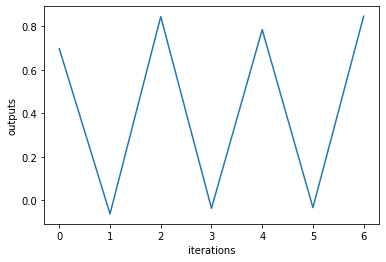

---------------
epoch 1500
sample 0
output: 
[[0.7718935]]
target: 
[[0.8]]
---------------
epoch 1500
sample 1
output: 
[[-0.06705489]]
target: 
[[0.0]]
---------------
epoch 1500
sample 2
output: 
[[0.82093663]]
target: 
[[0.8]]
---------------
epoch 1500
sample 3
output: 
[[-0.04077448]]
target: 
[[0.0]]
---------------
epoch 1500
sample 4
output: 
[[0.76931115]]
target: 
[[0.8]]
---------------
epoch 1500
sample 5
output: 
[[-0.03708953]]
target: 
[[0.0]]
---------------
epoch 1500
sample 6
output: 
[[0.82858033]]
target: 
[[0.8]]
-----------------average loss: [[0.00131519]]


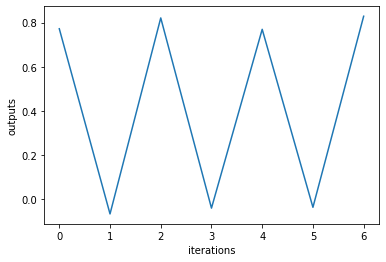

---------------
epoch 2000
sample 0
output: 
[[0.78591425]]
target: 
[[0.8]]
---------------
epoch 2000
sample 1
output: 
[[-0.0651447]]
target: 
[[0.0]]
---------------
epoch 2000
sample 2
output: 
[[0.81442788]]
target: 
[[0.8]]
---------------
epoch 2000
sample 3
output: 
[[-0.03959611]]
target: 
[[0.0]]
---------------
epoch 2000
sample 4
output: 
[[0.76844623]]
target: 
[[0.8]]
---------------
epoch 2000
sample 5
output: 
[[-0.03602723]]
target: 
[[0.0]]
---------------
epoch 2000
sample 6
output: 
[[0.82451389]]
target: 
[[0.8]]
-----------------average loss: [[0.0011391]]


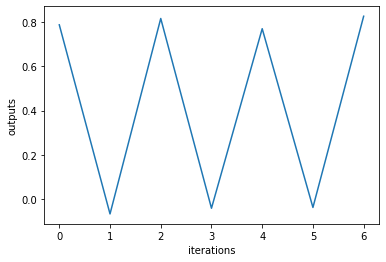

---------------
epoch 2500
sample 0
output: 
[[0.78893275]]
target: 
[[0.8]]
---------------
epoch 2500
sample 1
output: 
[[-0.06231596]]
target: 
[[0.0]]
---------------
epoch 2500
sample 2
output: 
[[0.81157753]]
target: 
[[0.8]]
---------------
epoch 2500
sample 3
output: 
[[-0.0376853]]
target: 
[[0.0]]
---------------
epoch 2500
sample 4
output: 
[[0.77029185]]
target: 
[[0.8]]
---------------
epoch 2500
sample 5
output: 
[[-0.03429627]]
target: 
[[0.0]]
---------------
epoch 2500
sample 6
output: 
[[0.82324937]]
target: 
[[0.8]]
-----------------average loss: [[0.00101992]]


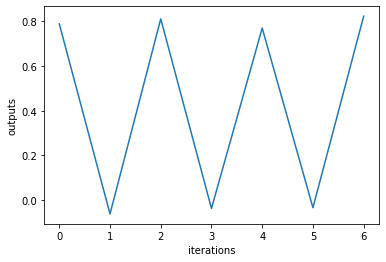

---------------
epoch 3000
sample 0
output: 
[[0.79004814]]
target: 
[[0.8]]
---------------
epoch 3000
sample 1
output: 
[[-0.05953579]]
target: 
[[0.0]]
---------------
epoch 3000
sample 2
output: 
[[0.80963569]]
target: 
[[0.8]]
---------------
epoch 3000
sample 3
output: 
[[-0.03579135]]
target: 
[[0.0]]
---------------
epoch 3000
sample 4
output: 
[[0.77233904]]
target: 
[[0.8]]
---------------
epoch 3000
sample 5
output: 
[[-0.03257698]]
target: 
[[0.0]]
---------------
epoch 3000
sample 6
output: 
[[0.82250406]]
target: 
[[0.8]]
-----------------average loss: [[0.00091878]]


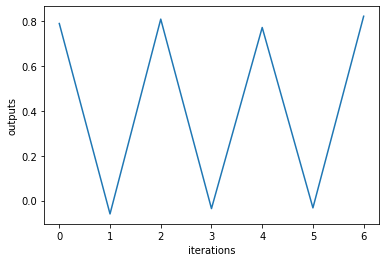

---------------
epoch 3500
sample 0
output: 
[[0.79078053]]
target: 
[[0.8]]
---------------
epoch 3500
sample 1
output: 
[[-0.05694011]]
target: 
[[0.0]]
---------------
epoch 3500
sample 2
output: 
[[0.80807906]]
target: 
[[0.8]]
---------------
epoch 3500
sample 3
output: 
[[-0.03402336]]
target: 
[[0.0]]
---------------
epoch 3500
sample 4
output: 
[[0.77419625]]
target: 
[[0.8]]
---------------
epoch 3500
sample 5
output: 
[[-0.03096963]]
target: 
[[0.0]]
---------------
epoch 3500
sample 6
output: 
[[0.82187692]]
target: 
[[0.8]]
-----------------average loss: [[0.0008317]]


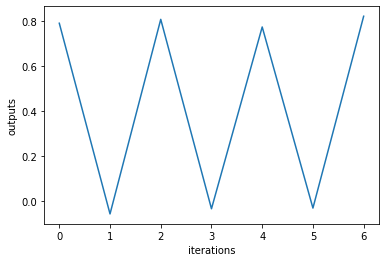

---------------
epoch 4000
sample 0
output: 
[[0.7913941]]
target: 
[[0.8]]
---------------
epoch 4000
sample 1
output: 
[[-0.05453046]]
target: 
[[0.0]]
---------------
epoch 4000
sample 2
output: 
[[0.80677714]]
target: 
[[0.8]]
---------------
epoch 4000
sample 3
output: 
[[-0.03238599]]
target: 
[[0.0]]
---------------
epoch 4000
sample 4
output: 
[[0.77583329]]
target: 
[[0.8]]
---------------
epoch 4000
sample 5
output: 
[[-0.02947937]]
target: 
[[0.0]]
---------------
epoch 4000
sample 6
output: 
[[0.82129623]]
target: 
[[0.8]]
-----------------average loss: [[0.00075613]]


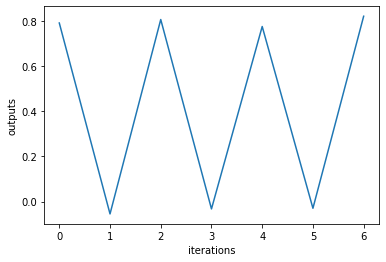

---------------
epoch 4500
sample 0
output: 
[[0.79194123]]
target: 
[[0.8]]
---------------
epoch 4500
sample 1
output: 
[[-0.05228979]]
target: 
[[0.0]]
---------------
epoch 4500
sample 2
output: 
[[0.80567475]]
target: 
[[0.8]]
---------------
epoch 4500
sample 3
output: 
[[-0.03086866]]
target: 
[[0.0]]
---------------
epoch 4500
sample 4
output: 
[[0.77727456]]
target: 
[[0.8]]
---------------
epoch 4500
sample 5
output: 
[[-0.02809724]]
target: 
[[0.0]]
---------------
epoch 4500
sample 6
output: 
[[0.82074703]]
target: 
[[0.8]]
-----------------average loss: [[0.00069007]]


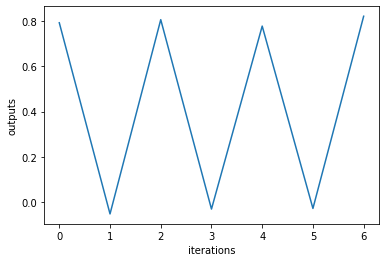

---------------
epoch 5000
sample 0
output: 
[[0.7924368]]
target: 
[[0.8]]
---------------
epoch 5000
sample 1
output: 
[[-0.05020076]]
target: 
[[0.0]]
---------------
epoch 5000
sample 2
output: 
[[0.80473636]]
target: 
[[0.8]]
---------------
epoch 5000
sample 3
output: 
[[-0.02945988]]
target: 
[[0.0]]
---------------
epoch 5000
sample 4
output: 
[[0.77854831]]
target: 
[[0.8]]
---------------
epoch 5000
sample 5
output: 
[[-0.02681329]]
target: 
[[0.0]]
---------------
epoch 5000
sample 6
output: 
[[0.82022461]]
target: 
[[0.8]]
-----------------average loss: [[0.00063197]]


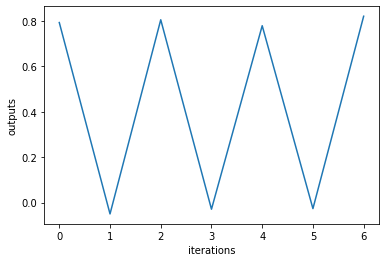

---------------
epoch 5500
sample 0
output: 
[[0.79288818]]
target: 
[[0.8]]
---------------
epoch 5500
sample 1
output: 
[[-0.0482483]]
target: 
[[0.0]]
---------------
epoch 5500
sample 2
output: 
[[0.80393492]]
target: 
[[0.8]]
---------------
epoch 5500
sample 3
output: 
[[-0.02814935]]
target: 
[[0.0]]
---------------
epoch 5500
sample 4
output: 
[[0.77967907]]
target: 
[[0.8]]
---------------
epoch 5500
sample 5
output: 
[[-0.02561848]]
target: 
[[0.0]]
---------------
epoch 5500
sample 6
output: 
[[0.81972635]]
target: 
[[0.8]]
-----------------average loss: [[0.00058059]]


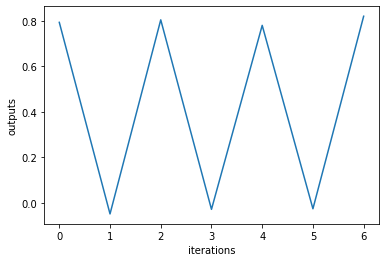

---------------
epoch 6000
sample 0
output: 
[[0.79330074]]
target: 
[[0.8]]
---------------
epoch 6000
sample 1
output: 
[[-0.0464195]]
target: 
[[0.0]]
---------------
epoch 6000
sample 2
output: 
[[0.80324883]]
target: 
[[0.8]]
---------------
epoch 6000
sample 3
output: 
[[-0.02692806]]
target: 
[[0.0]]
---------------
epoch 6000
sample 4
output: 
[[0.78068728]]
target: 
[[0.8]]
---------------
epoch 6000
sample 5
output: 
[[-0.02450487]]
target: 
[[0.0]]
---------------
epoch 6000
sample 6
output: 
[[0.81925023]]
target: 
[[0.8]]
-----------------average loss: [[0.00053492]]


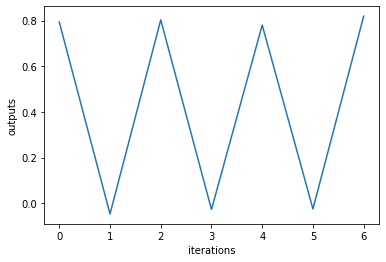

---------------
epoch 6500
sample 0
output: 
[[0.7936789]]
target: 
[[0.8]]
---------------
epoch 6500
sample 1
output: 
[[-0.04470328]]
target: 
[[0.0]]
---------------
epoch 6500
sample 2
output: 
[[0.80266049]]
target: 
[[0.8]]
---------------
epoch 6500
sample 3
output: 
[[-0.02578811]]
target: 
[[0.0]]
---------------
epoch 6500
sample 4
output: 
[[0.78158992]]
target: 
[[0.8]]
---------------
epoch 6500
sample 5
output: 
[[-0.02346543]]
target: 
[[0.0]]
---------------
epoch 6500
sample 6
output: 
[[0.81879452]]
target: 
[[0.8]]
-----------------average loss: [[0.00049415]]


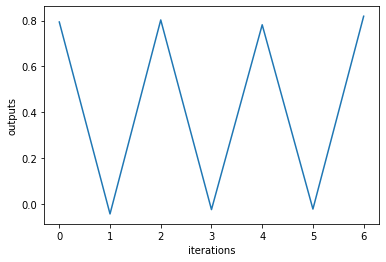

---------------
epoch 7000
sample 0
output: 
[[0.7940264]]
target: 
[[0.8]]
---------------
epoch 7000
sample 1
output: 
[[-0.04309]]
target: 
[[0.0]]
---------------
epoch 7000
sample 2
output: 
[[0.80215543]]
target: 
[[0.8]]
---------------
epoch 7000
sample 3
output: 
[[-0.02472252]]
target: 
[[0.0]]
---------------
epoch 7000
sample 4
output: 
[[0.78240115]]
target: 
[[0.8]]
---------------
epoch 7000
sample 5
output: 
[[-0.02249394]]
target: 
[[0.0]]
---------------
epoch 7000
sample 6
output: 
[[0.81835771]]
target: 
[[0.8]]
-----------------average loss: [[0.00045762]]


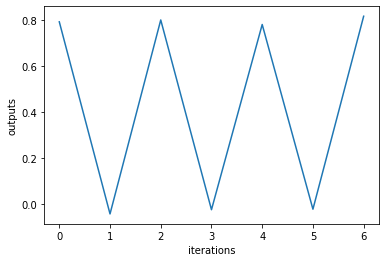

---------------
epoch 7500
sample 0
output: 
[[0.79434649]]
target: 
[[0.8]]
---------------
epoch 7500
sample 1
output: 
[[-0.04157125]]
target: 
[[0.0]]
---------------
epoch 7500
sample 2
output: 
[[0.80172164]]
target: 
[[0.8]]
---------------
epoch 7500
sample 3
output: 
[[-0.02372512]]
target: 
[[0.0]]
---------------
epoch 7500
sample 4
output: 
[[0.78313287]]
target: 
[[0.8]]
---------------
epoch 7500
sample 5
output: 
[[-0.02158483]]
target: 
[[0.0]]
---------------
epoch 7500
sample 6
output: 
[[0.81793845]]
target: 
[[0.8]]
-----------------average loss: [[0.00042477]]


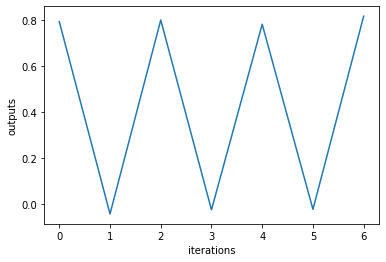

---------------
epoch 8000
sample 0
output: 
[[0.79464196]]
target: 
[[0.8]]
---------------
epoch 8000
sample 1
output: 
[[-0.04013956]]
target: 
[[0.0]]
---------------
epoch 8000
sample 2
output: 
[[0.80134913]]
target: 
[[0.8]]
---------------
epoch 8000
sample 3
output: 
[[-0.02279036]]
target: 
[[0.0]]
---------------
epoch 8000
sample 4
output: 
[[0.78379516]]
target: 
[[0.8]]
---------------
epoch 8000
sample 5
output: 
[[-0.0207331]]
target: 
[[0.0]]
---------------
epoch 8000
sample 6
output: 
[[0.81753555]]
target: 
[[0.8]]
-----------------average loss: [[0.00039513]]


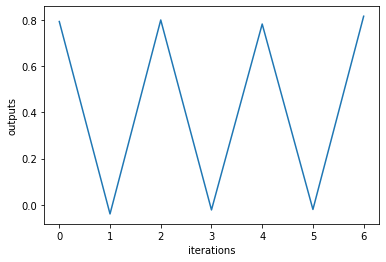

---------------
epoch 8500
sample 0
output: 
[[0.79491524]]
target: 
[[0.8]]
---------------
epoch 8500
sample 1
output: 
[[-0.0387883]]
target: 
[[0.0]]
---------------
epoch 8500
sample 2
output: 
[[0.80102949]]
target: 
[[0.8]]
---------------
epoch 8500
sample 3
output: 
[[-0.02191328]]
target: 
[[0.0]]
---------------
epoch 8500
sample 4
output: 
[[0.78439654]]
target: 
[[0.8]]
---------------
epoch 8500
sample 5
output: 
[[-0.01993425]]
target: 
[[0.0]]
---------------
epoch 8500
sample 6
output: 
[[0.81714794]]
target: 
[[0.8]]
-----------------average loss: [[0.00036832]]


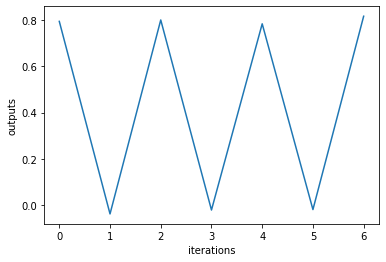

---------------
epoch 9000
sample 0
output: 
[[0.79516848]]
target: 
[[0.8]]
---------------
epoch 9000
sample 1
output: 
[[-0.03751152]]
target: 
[[0.0]]
---------------
epoch 9000
sample 2
output: 
[[0.80075564]]
target: 
[[0.8]]
---------------
epoch 9000
sample 3
output: 
[[-0.02108939]]
target: 
[[0.0]]
---------------
epoch 9000
sample 4
output: 
[[0.78494433]]
target: 
[[0.8]]
---------------
epoch 9000
sample 5
output: 
[[-0.01918419]]
target: 
[[0.0]]
---------------
epoch 9000
sample 6
output: 
[[0.81677463]]
target: 
[[0.8]]
-----------------average loss: [[0.00034399]]


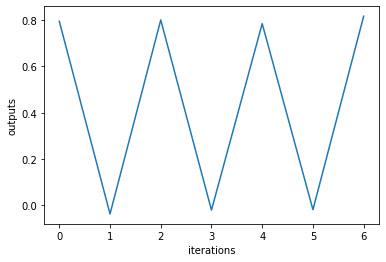

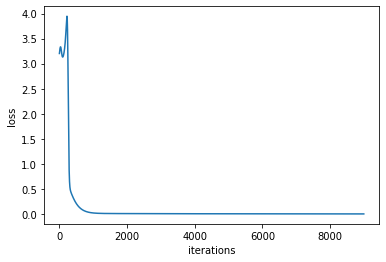

------------training finished successfully!------------


In [4]:
epochs = 9000
batch = 2
early_stop = 500
loss = 0
prevLoss = 999
losses = []

for e in range(0, epochs+1):
    network.clear_memory()
    loss = 0
    outputs = []
    for i in range(0, len(input_data)-1):
        output = network.forward_pass(input_data[i])
        outputs.append(output)
        loss += network.backpropagation_through_time(input_data, input_data[i+1], 3)
        if e%500 == 0:
            print("---------------")
            print("epoch " + str(e))
            print("sample " + str(i))
            print("output: \n" + str(output))
            print("target: \n" + str(input_data[i+1]))
    
    if e%500 == 0:        
        print("-----------------average loss: " + str(loss/len(input_data))) 
        plt.plot(np.squeeze(outputs))
        plt.ylabel('outputs')
        plt.xlabel('iterations')
        plt.show()
        
        
    prevLoss = loss
    losses.append(loss)
    
plt.plot(np.squeeze(losses))
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()
    
print("------------training finished successfully!------------")
        